In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# import pandas as pd

# # 파일 경로 설정
# file_path = 'tofdrug2_ko.csv'

# # tofdrug.csv 파일 읽기
# df = pd.read_csv(file_path, encoding='utf-8')

# # 랜덤으로 100개의 행 선택
# df_sample = df.sample(n=100, random_state=1)

# # 새로운 CSV 파일로 저장
# output_path = 'tofdrug_sample100.csv'
# df_sample.to_csv(output_path, index=False, encoding='utf-8-sig')

# output_path

In [13]:
# unique_route_source_values = df_sample['route_source_value'].unique()
# print(unique_route_source_values)


In [14]:
# tofdrug_sample100.csv 파일 읽기
df = pd.read_csv('tofdrug2_ko.csv', encoding='utf-8')

# drug_concept_id 및 source_name 컬럼에 따른 처방 통계 계산
prescription_stats = df.groupby(['drug_concept_id', 'source_name', 'atc_cd']).size().reset_index(name='count')

# 처방받은 횟수에 따라 내림차순으로 정렬
prescription_stats_sorted = prescription_stats.sort_values(by='count', ascending=False)

prescription_stats_sorted.head(10)


,drug_concept_id,source_name,atc_cd,count
421,19079658,Spironolactone 25mg tab,C03DA01,28710
82,957136,Furosemide 40mg tab,C03CA01,28287
587,21138024,Salbutamol 2.5mg nebule inhaler,R03AC02,26708
789,40165789,Enalapril 5mg tab,C09AA02,23732
696,36249739,Dextrose 5% 50ml btl,B05BA03,20804
1320,43296872,Acetylcysteine 20% 4ml inhaler,R05CB01,19925
846,40221384,Normal saline 0.9% 50ml btl,B05XA03,17824
203,1718698,Potassium chloride 40mEq/20ml inj,B05XA01,15554
429,19088169,Ambroxol 3mg/ml syrup,R05CB06,14800
112,1113143,Aspirin 100mg tab,N02BA01,13536


In [15]:
# 'source_name' 열에서 'Normal saline'을 포함하는 행 확인
normal_saline_data = df[df['source_name'].str.contains('Normal saline', na=False)]

# 'source_name' 열과 'route_source_value' 열에서 고유한 값 출력
unique_values = normal_saline_data[['source_name', 'route_source_value']].drop_duplicates()
print(unique_values)


                                            source_name route_source_value
106294            Amikacin/Normal saline 250mg/50ml inj                 주사
238788  Normal saline(NaCl 0.9%) 10mL Prefilled syringe                 주사
250882                 Normal saline 0.9% K20 100mL btl                 주사
342385               Dextrose 5% & Normal saline 1L bag                 주사
409569                             Normal saline 3L bag                 주사
461758                       Normal saline 0.45% 1L bag                 주사
462085                     Normal saline 0.9% 150ml btl                 주사
462891                      Normal saline 0.9% 50ml btl                 주사
480705                     Normal saline 0.9% 100ml bag                 주사
487540                     Normal saline 0.9% 250ml bag                 주사
488266                     Normal saline 0.9% 500ml btl                 주사
491069              Normal saline 0.9% 20ml plastic inj                 주사
527288                   

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_1488\654166406.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="count", y="source_name", data=top_prescriptions, palette="coolwarm")


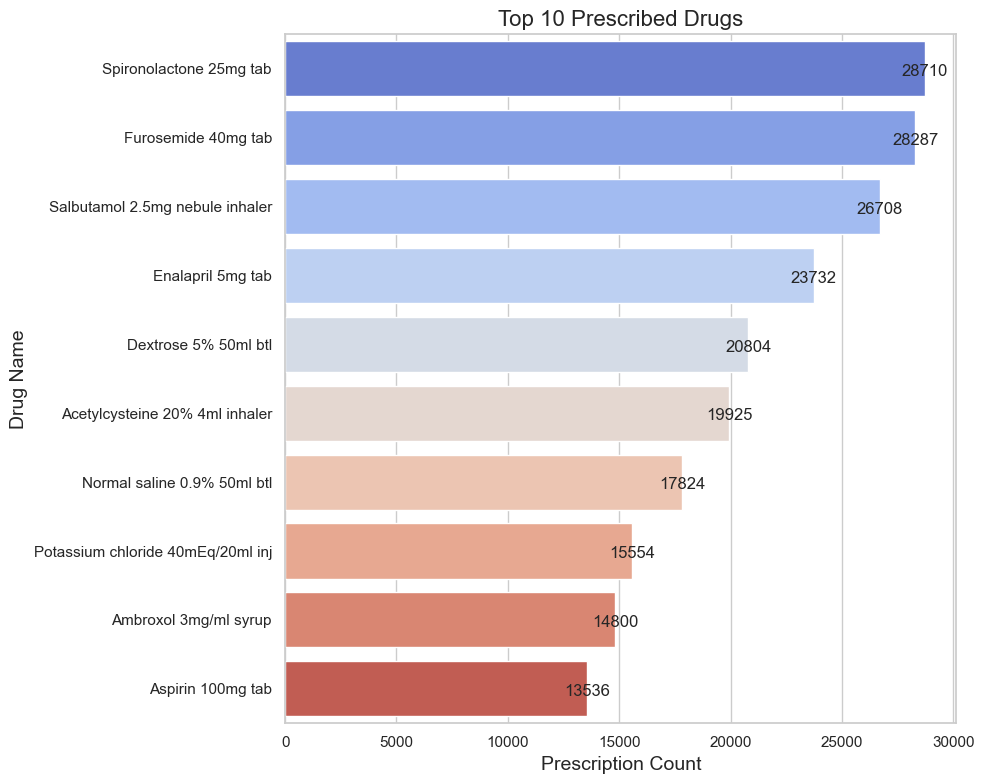

In [16]:
# 시각화를 위한 데이터 준비
top_prescriptions = prescription_stats_sorted.head(10)

# Seaborn 스타일 설정
sns.set(style="whitegrid")

# 그래프 크기 설정
plt.figure(figsize=(10, 8))

# 수평 막대 그래프 생성
ax = sns.barplot(x="count", y="source_name", data=top_prescriptions, palette="coolwarm")

# 제목 및 라벨 설정
ax.set_title('Top 10 Prescribed Drugs', fontsize=16)
ax.set_xlabel('Prescription Count', fontsize=14)
ax.set_ylabel('Drug Name', fontsize=14)

# 값을 막대 위에 표시
for p in ax.patches:
    width = p.get_width()
    plt.text(5+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.0f}'.format(width),
             ha='center', va='center')

plt.tight_layout()
plt.show()


In [17]:
import re

# 먼저, 약물 이름을 단순화하기 전에 source_name과 atc_cd 간의 매핑을 생성합니다.
source_atc_mapping = df[['source_name', 'atc_cd']].drop_duplicates()

# 약물 이름에서 용량과 관련된 정보를 제거하는 함수
def simplify_drug_name(name):
    # 용량, 용기, 제형 등을 제거
    simplified_name = re.sub(r'\s+\d*\.?\d*\s*(mg|ml|mEq|g|%|L|unit)(/\d*\.?\d*\s*(mg|ml|mEq|g|%|L|unit))?|\d*\.?\d*unit/\w+|\s+\d+\s*|\s+tab|\s+btl|\s+inj|\s+nebule|\s+bag', '', name, flags=re.I)
    simplified_name = re.sub(r'[,*]', '', simplified_name).strip()
    return simplified_name.strip()

# 다음으로, df에 simplified_drug_name 컬럼을 추가합니다.
df['simplified_drug_name'] = df['source_name'].apply(simplify_drug_name)

# simplified_drug_name 기준으로 atc_cd를 매핑하기 위해, 먼저 source_name을 기준으로 atc_cd를 merge합니다.
df_atc = pd.merge(df, source_atc_mapping, on='source_name', how='left')

# 이제 simplified_drug_name 및 atc_cd에 따라 처방 통계를 계산합니다.
simplified_prescription_stats_with_atc = df_atc.groupby(['simplified_drug_name', 'atc_cd_y']).size().reset_index(name='count')

# 처방받은 횟수에 따라 내림차순으로 정렬
simplified_prescription_stats_with_atc_sorted = simplified_prescription_stats_with_atc.sort_values(by='count', ascending=False)

# 상위 10개 결과 출력을 시도합니다.
simplified_prescription_stats_with_atc_sorted.head(10)


,simplified_drug_name,atc_cd_y,count
307,Dextrose,B05BA03,50021
445,Furosemide,C03CA01,40818
738,Normal saline,B05XA03,36598
955,Spironolactone,C03DA01,28710
917,Salbutamol inhaler,R03AC02,26708
354,Enalapril,C09AA02,23934
15,Acetylcysteine inhaler,R05CB01,19925
387,Famotidine,A02BA03,16959
825,Potassium chloride,B05XA01,15554
52,Ambroxol syrup,R05CB06,14800


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_1488\4083467876.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="count", y="simplified_drug_name", data=top_simplified_prescriptions, palette="coolwarm")


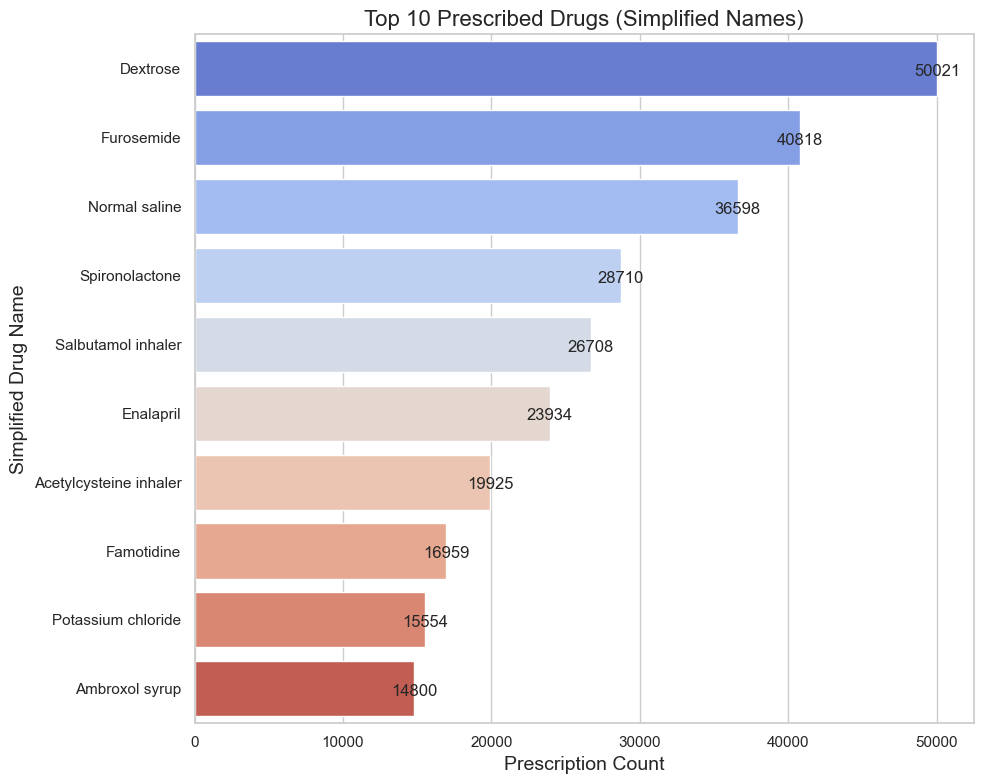

In [18]:
# 시각화를 위한 데이터 준비
top_simplified_prescriptions = simplified_prescription_stats_with_atc_sorted.head(10)

# 그래프 크기 설정
plt.figure(figsize=(10, 8))

# Seaborn 스타일 설정
sns.set(style="whitegrid")

# 수평 막대 그래프 생성
ax = sns.barplot(x="count", y="simplified_drug_name", data=top_simplified_prescriptions, palette="coolwarm")

# 제목 및 라벨 설정
ax.set_title('Top 10 Prescribed Drugs (Simplified Names)', fontsize=16)
ax.set_xlabel('Prescription Count', fontsize=14)
ax.set_ylabel('Simplified Drug Name', fontsize=14)

# 값을 막대 위에 표시
for p in ax.patches:
    width = p.get_width()
    plt.text(5+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.0f}'.format(width),
             ha='center', va='center')

plt.tight_layout()
plt.show()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_1488\748221521.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="count", y="simplified_drug_name", data=top_unique_prescriptions_counts, palette="coolwarm")


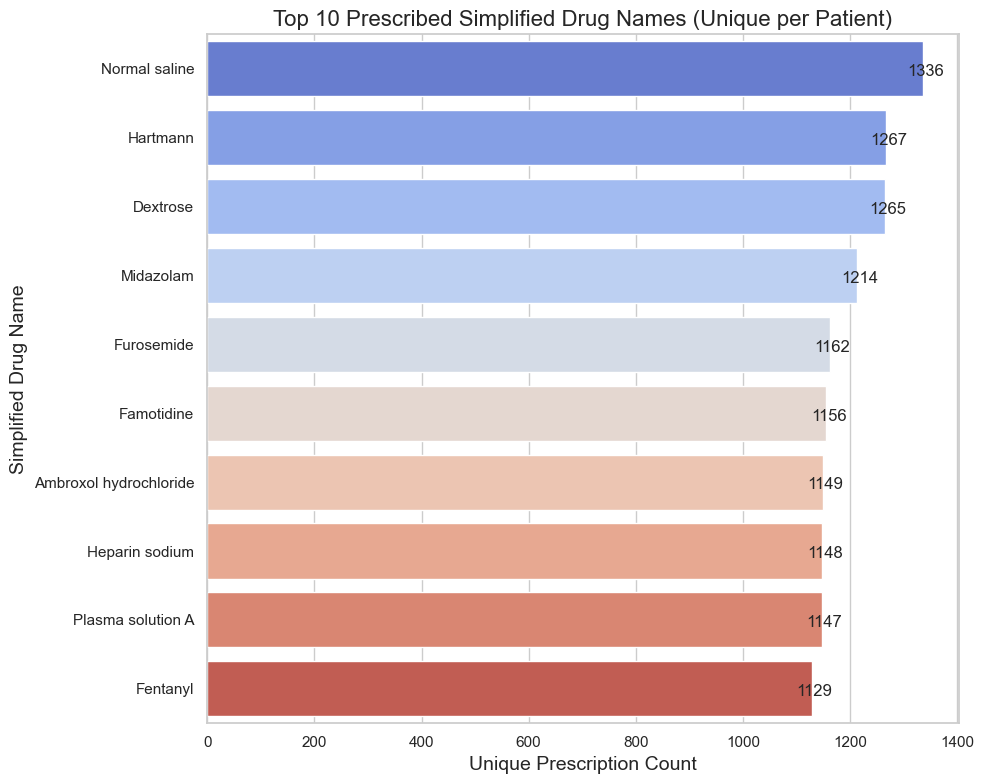

In [19]:
# 환자 ID와 단순화된 약물 이름을 기준으로 중복 제거
unique_prescriptions = df[['person_id', 'simplified_drug_name']].drop_duplicates()

# 중복 제거된 데이터를 사용하여 단순화된 약물 이름에 따른 처방 통계 재계산
unique_prescription_counts = unique_prescriptions.groupby('simplified_drug_name').size().reset_index(name='count')

# 처방받은 횟수에 따라 내림차순으로 정렬
unique_prescription_counts_sorted = unique_prescription_counts.sort_values(by='count', ascending=False)

# 시각화를 위한 상위 10개 선택
top_unique_prescriptions_counts = unique_prescription_counts_sorted.head(10)

# 시각화
plt.figure(figsize=(10, 8))
ax = sns.barplot(x="count", y="simplified_drug_name", data=top_unique_prescriptions_counts, palette="coolwarm")
ax.set_title('Top 10 Prescribed Simplified Drug Names (Unique per Patient)', fontsize=16)
ax.set_xlabel('Unique Prescription Count', fontsize=14)
ax.set_ylabel('Simplified Drug Name', fontsize=14)
for p in ax.patches:
    width = p.get_width()
    plt.text(5+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.0f}'.format(width),
             ha='center', va='center')
plt.tight_layout()
plt.show()


In [20]:
# 환자 ID, 단순화된 약물 이름, 그리고 atc_cd를 기준으로 중복 제거
unique_prescriptions_with_atc = df[['person_id', 'simplified_drug_name', 'atc_cd']].drop_duplicates()

# 중복 제거된 데이터를 사용하여 단순화된 약물 이름과 atc_cd에 따른 처방 통계 재계산
unique_prescription_counts_with_atc = unique_prescriptions_with_atc.groupby(['simplified_drug_name', 'atc_cd']).size().reset_index(name='count')

# 처방받은 횟수에 따라 내림차순으로 정렬
unique_prescription_counts_with_atc_sorted = unique_prescription_counts_with_atc.sort_values(by='count', ascending=False)

# 상위 10개 결과 출력
unique_prescription_counts_with_atc_sorted.head(10)


,simplified_drug_name,atc_cd,count
738,Normal saline,B05XA03,1336
473,Hartmann,B05BB01,1267
307,Dextrose,B05BA03,1265
673,Midazolam,N05CD08,1214
445,Furosemide,C03CA01,1162
387,Famotidine,A02BA03,1156
51,Ambroxol hydrochloride,R05CB06,1149
477,Heparin sodium,B01AB01,1148
814,Plasma solution A,B05BB04,1147
1008,Thiopental,N01AF03,1124


In [21]:
# 환자 ID, 단순화된 약물 이름, 그리고 atc_cd를 기준으로 중복 제거
unique_prescriptions_with_atc = df[['person_id', 'simplified_drug_name', 'atc_cd']].drop_duplicates()

# 중복 제거된 데이터를 사용하여 단순화된 약물 이름과 atc_cd에 따른 처방 통계 재계산
unique_prescription_counts_with_atc = unique_prescriptions_with_atc.groupby(['simplified_drug_name', 'atc_cd']).size().reset_index(name='count')

# 처방받은 횟수에 따라 내림차순으로 정렬
unique_prescription_counts_with_atc_sorted = unique_prescription_counts_with_atc.sort_values(by='count', ascending=False)

# 상위 10개 결과 출력
unique_prescription_counts_with_atc_sorted.head(30)


,simplified_drug_name,atc_cd,count
738,Normal saline,B05XA03,1336
473,Hartmann,B05BB01,1267
307,Dextrose,B05BA03,1265
673,Midazolam,N05CD08,1214
445,Furosemide,C03CA01,1162
387,Famotidine,A02BA03,1156
51,Ambroxol hydrochloride,R05CB06,1149
477,Heparin sodium,B01AB01,1148
814,Plasma solution A,B05BB04,1147
1008,Thiopental,N01AF03,1124


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_1488\4267966439.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="count", y="simplified_drug_name", data=top_unique_prescriptions_counts, palette="coolwarm")


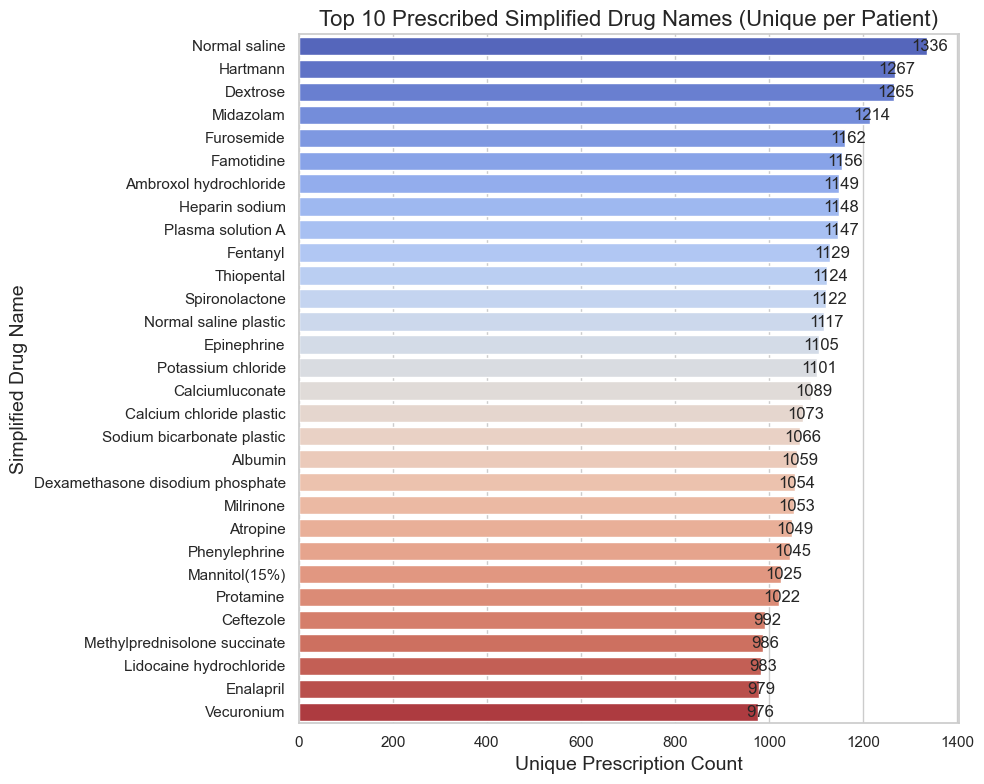

In [22]:
# 시각화를 위한 상위 10개 선택
top_unique_prescriptions_counts = unique_prescription_counts_sorted.head(30)

# 시각화
plt.figure(figsize=(10, 8))
ax = sns.barplot(x="count", y="simplified_drug_name", data=top_unique_prescriptions_counts, palette="coolwarm")
ax.set_title('Top 10 Prescribed Simplified Drug Names (Unique per Patient)', fontsize=16)
ax.set_xlabel('Unique Prescription Count', fontsize=14)
ax.set_ylabel('Simplified Drug Name', fontsize=14)
for p in ax.patches:
    width = p.get_width()
    plt.text(5+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.0f}'.format(width),
             ha='center', va='center')
plt.tight_layout()
plt.show()
